In [34]:
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics, optimizers, callbacks
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from imblearn.metrics import classification_report_imbalanced

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt
import requests

## Reading the dataset

In [2]:
df = (
    pd.read_csv("./DryBeanDataset/Dry_Bean_Dataset.csv")
    .sample(frac=1)
    .reset_index(drop=True)
)
# df = pd.read_csv("./selected_features/Anova.csv")

In [3]:
df.head(10)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,68852,981.885,354.744204,248.506994,1.427502,0.713628,69563,296.082909,0.774001,0.989779,0.897439,0.834638,0.005152,0.001542,0.696620,0.994427,BARBUNYA
1,36109,690.918,236.918386,194.403861,1.218692,0.571572,36461,214.418765,0.771560,0.990346,0.950544,0.905032,0.006561,0.002715,0.819083,0.998210,SEKER
2,37177,707.976,259.312475,182.921571,1.417616,0.708800,37528,217.566603,0.803827,0.990647,0.932067,0.839013,0.006975,0.002132,0.703943,0.997921,DERMASON
3,36730,692.349,235.968065,198.496267,1.188778,0.540725,37038,216.254684,0.766678,0.991684,0.962899,0.916457,0.006424,0.002796,0.839894,0.998448,SEKER
4,49728,823.685,285.910127,221.804301,1.289020,0.630999,50280,251.626024,0.779595,0.989021,0.921061,0.880088,0.005749,0.002128,0.774555,0.998416,SEKER
5,45325,801.826,301.858749,192.067748,1.571626,0.771455,45963,240.228188,0.800230,0.986119,0.885906,0.795830,0.006660,0.001648,0.633345,0.995382,SIRA
6,47044,855.838,354.304435,170.357301,2.079773,0.876818,47566,244.741253,0.621699,0.989026,0.807107,0.690765,0.007531,0.001058,0.477157,0.992378,HOROZ
7,60868,1018.898,416.225028,187.510757,2.219739,0.892775,61982,278.387400,0.760869,0.982027,0.736779,0.668839,0.006838,0.000844,0.447345,0.992990,HOROZ
8,175276,1595.654,608.730967,368.763860,1.650734,0.795624,177114,472.406958,0.789343,0.989623,0.865077,0.776052,0.003473,0.000777,0.602257,0.994166,BOMBAY
9,51650,906.338,368.488038,179.682191,2.050777,0.873056,52390,256.442630,0.668046,0.985875,0.790132,0.695932,0.007134,0.001032,0.484321,0.993235,HOROZ


## Creating the model

In [17]:
net = tf.keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(7),
    ]
)

In [19]:
X = df.drop(columns=["Class"]).values
y = df.Class.astype('category').cat.codes.values

### Without Resampling

In [7]:
# scaling the the data for training!
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train = scaler.fit_transform(X_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

In [24]:
net.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

In [10]:
history = net.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        callbacks.ModelCheckpoint("models/4", save_best_only=True, verbose=3),
    ],
)

Epoch 1/20
237/240 [============================>.] - ETA: 0s - loss: 0.5086 - sparse_categorical_accuracy: 0.8463
Epoch 00001: val_loss improved from inf to 0.24519, saving model to models\4
INFO:tensorflow:Assets written to: models\4\assets
240/240 [==============================] - 3s 8ms/step - loss: 0.5060 - sparse_categorical_accuracy: 0.8470 - val_loss: 0.2452 - val_sparse_categorical_accuracy: 0.9103
Epoch 2/20
228/240 [===========================>..] - ETA: 0s - loss: 0.2295 - sparse_categorical_accuracy: 0.9211
Epoch 00002: val_loss improved from 0.24519 to 0.21605, saving model to models\4
INFO:tensorflow:Assets written to: models\4\assets
240/240 [==============================] - 1s 6ms/step - loss: 0.2278 - sparse_categorical_accuracy: 0.9216 - val_loss: 0.2160 - val_sparse_categorical_accuracy: 0.9212
Epoch 3/20
229/240 [===========================>..] - ETA: 0s - loss: 0.2096 - sparse_categorical_accuracy: 0.9233
Epoch 00003: val_loss improved from 0.21605 to 0.20884, s

In [11]:
# Transforming the test set

X_test = scaler.transform(X_test)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

In [12]:
net.evaluate(test_ds)

213/213 [==============================] - 0s 2ms/step - loss: 0.1947 - sparse_categorical_accuracy: 0.9304


[0.19465896487236023, 0.9303555488586426]

In [13]:
preds = net(X_test)
preds = tf.argmax(preds, axis=1)

In [15]:
preds.numpy()

array([4, 5, 5, ..., 3, 3, 1], dtype=int64)

In [16]:
f1_score(y_true=y_test, y_pred=preds.numpy(), average='weighted')

0.9298963069257667

In [15]:
cf = confusion_matrix(y_test, preds)

classes = df.Class.astype("category").cat.categories.tolist()
print(classification_report_imbalanced(y_test, preds, target_names=classes))

                   pre       rec       spe        f1       geo       iba       sup

   BARBUNYA       0.95      0.96      0.99      0.96      0.98      0.95       335
     BOMBAY       1.00      1.00      1.00      1.00      1.00      1.00       150
       CALI       0.96      0.96      0.99      0.96      0.97      0.95       386
   DERMASON       0.92      0.91      0.97      0.91      0.94      0.88       893
      HOROZ       0.96      0.96      0.99      0.96      0.98      0.95       458
      SEKER       0.96      0.95      0.99      0.96      0.97      0.94       512
       SIRA       0.85      0.88      0.96      0.86      0.92      0.84       669

avg / total       0.93      0.93      0.98      0.93      0.96      0.91      3403



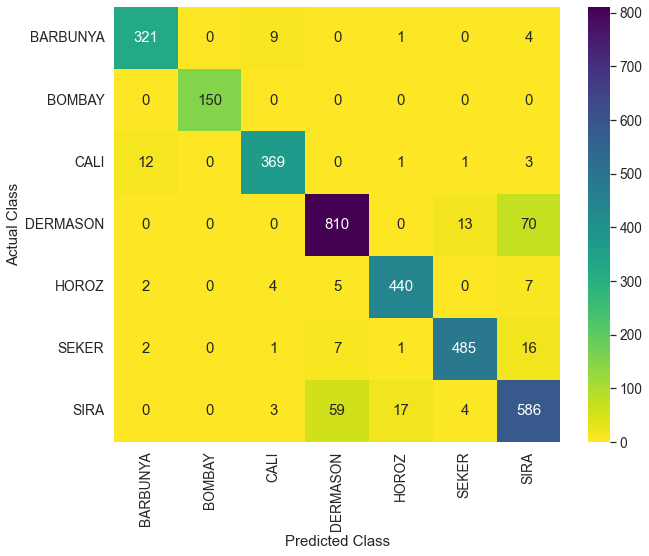

In [17]:
classes = df.Class.astype("category").cat.categories.tolist()
sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)
ax = sns.heatmap(
    cf, annot=True, xticklabels=classes, yticklabels=classes, fmt="d", cmap="viridis_r"
)
ax.set_ylabel("Actual Class")
_ = ax.set_xlabel("Predicted Class")

### With SMOTE Oversampling

In [20]:
X_sampled, y_sampled = SMOTE().fit_resample(X, y) 

In [21]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.25)

X_train = scaler.fit_transform(X_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [22]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

In [25]:
history = net.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        callbacks.ModelCheckpoint("models/5", save_best_only=True, verbose=3),
    ],
)

Epoch 1/20
436/437 [============================>.] - ETA: 0s - loss: 0.3504 - sparse_categorical_accuracy: 0.8898
Epoch 00001: val_loss improved from inf to 0.18167, saving model to models\5
INFO:tensorflow:Assets written to: models\5\assets
437/437 [==============================] - 2s 5ms/step - loss: 0.3502 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.1817 - val_sparse_categorical_accuracy: 0.9439
Epoch 2/20
425/437 [============================>.] - ETA: 0s - loss: 0.1632 - sparse_categorical_accuracy: 0.9418
Epoch 00002: val_loss improved from 0.18167 to 0.16037, saving model to models\5
INFO:tensorflow:Assets written to: models\5\assets
437/437 [==============================] - 3s 6ms/step - loss: 0.1634 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.1604 - val_sparse_categorical_accuracy: 0.9491
Epoch 3/20
424/437 [============================>.] - ETA: 0s - loss: 0.1518 - sparse_categorical_accuracy: 0.9448
Epoch 00003: val_loss improved from 0.16037 to 0.15337, s

In [27]:
X_test = scaler.transform(X_test)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)
net.evaluate(test_ds)

388/388 [==============================] - 1s 3ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9484


[0.13477090001106262, 0.948436975479126]

In [28]:
preds = net(X_test)
preds = tf.argmax(preds, axis=1)
preds.numpy()

array([4, 1, 0, ..., 0, 4, 3], dtype=int64)

In [29]:
f1_score(y_test, preds, average='weighted')

0.9484439923152497

In [31]:
print(classification_report_imbalanced(y_test, preds))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.94      1.00      0.96      0.97      0.93       874
          1       1.00      1.00      1.00      1.00      1.00      1.00       923
          2       0.94      0.97      0.99      0.96      0.98      0.96       847
          3       0.93      0.89      0.99      0.91      0.94      0.87       888
          4       0.98      0.96      1.00      0.97      0.98      0.95       914
          5       0.93      0.98      0.99      0.96      0.99      0.97       891
          6       0.88      0.90      0.98      0.89      0.94      0.87       869

avg / total       0.95      0.95      0.99      0.95      0.97      0.94      6206



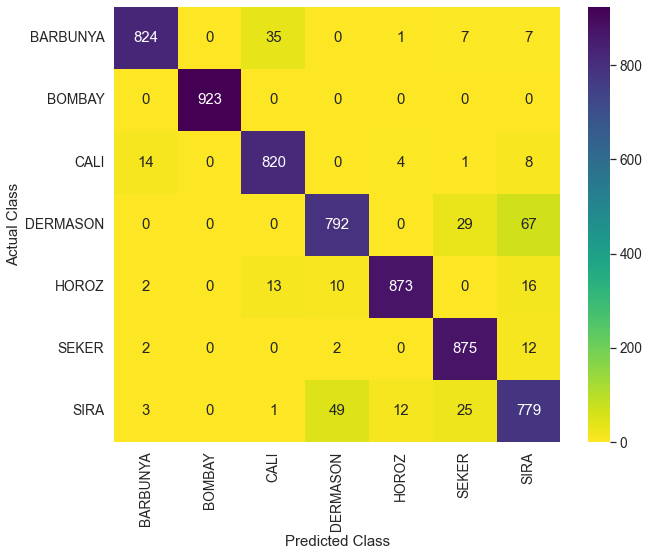

In [33]:
cf = confusion_matrix(y_test, preds)

classes = df.Class.astype("category").cat.categories.tolist()
sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)
ax = sns.heatmap(
    cf, annot=True, xticklabels=classes, yticklabels=classes, fmt="d", cmap="viridis_r"
)
ax.set_ylabel("Actual Class")
_ = ax.set_xlabel("Predicted Class")